In [71]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, glob, os
import scipy.stats as stats, scipy.io as sio
from scipy.ndimage import gaussian_filter1d
from neo.io import BlackrockIO
from nilearn import datasets, plotting

In [93]:
patient = 12

### create QC file

In [94]:
df_rows = []
# to get channel & unit IDs
fig_files = glob.glob(f'../../results/2025{patient}/osort_mat/figs/5/*')

for fig_file in sorted(fig_files):

    # skip raw fig files, and all-unit fig files
    if 'CL' not in fig_file or 'ALL' in fig_file: continue
    
    chanID = int(os.path.basename(fig_file).split('_')[0][1:])
    unitID = int(os.path.basename(fig_file).split('_')[2])
    df_rows.append((chanID, unitID))

# sort properly by channel then unit
df_rows_sorted = sorted(df_rows, key=lambda x: (x[0], x[1]))
    
chanID_df = pd.DataFrame(df_rows_sorted, columns=['chanID', 'unitID'])
chanID_df.to_csv(f'../../results/2025{patient}/records/chanID_pt{patient}.csv', index=False)
chanID_df

,chanID,unitID
0,97,596
1,97,612
2,98,1432
3,98,1502
4,98,1543
...,...,...
85,126,156
86,127,182
87,127,188
88,128,167


### perform manual QC. then load:

debug

In [95]:
QC_df = pd.read_csv(f'../../results/2025{patient}/records/QC_pt{patient}.csv')
chanID_df = pd.read_csv(f'../../results/2025{patient}/records/chanID_pt{patient}.csv')

QC_u = QC_df.dropna(subset=['unitID'])
CH_u = chanID_df.dropna(subset=['unitID'])

QC_only  = QC_u[~QC_u.unitID.isin(CH_u.unitID)]
CH_only  = CH_u[~CH_u.unitID.isin(QC_u.unitID)]

print(QC_only)
print(CH_only)



Empty DataFrame
Columns: [chanID, unitID, keep, notes]
Index: []
Empty DataFrame
Columns: [chanID, unitID]
Index: []


In [96]:
QC_df = pd.read_csv(f'../../results/2025{patient}/records/QC_pt{patient}.csv')

# clean
QC_df['keep'] = QC_df['keep'].fillna(0)
dropped_clustIDs = QC_df[QC_df['keep'] != 1]['unitID'].astype(int).tolist()
dropped_clustIDs.extend([0, 1, 99999999])
QC_df = QC_df[~QC_df['unitID'].isin(dropped_clustIDs)].copy().reset_index(drop=True)

QC_df

,chanID,unitID,keep,notes
0,97,612,1.0,isolation
1,98,1583,1.0,NaN
2,99,703,1.0,NaN
3,100,683,1.0,isolation
4,101,952,1.0,NaN
5,102,2460,1.0,NaN
6,102,2475,1.0,isolation
7,102,2477,1.0,NaN
8,103,1466,1.0,isolation
9,104,2349,1.0,isolation


In [97]:
def getclustID2spikes(clustIDs, spikes):
    ''' return dict with keys=unique clusters, and vals = list of corresponding spikes '''
    
    dropped_clustIDs.extend([0, 1, 99999999])  # also drop these
    clust2spikes = {}
    for clustID, spike in zip(clustIDs, spikes):

        if clustID in dropped_clustIDs: continue

        if clustID not in clust2spikes: clust2spikes[clustID] = [] # init

        clust2spikes[clustID].append(spike)

    return clust2spikes

### create initial df with chanID, clustID, spikes, #spikes, avgFR
 

In [98]:
samp_rate = 1000000
neur_spikes_df = []

# go through OSort mat files
for mat_file in glob.glob(f'../../results/2025{patient}/osort_mat/sort/5/*_sorted_new.mat'):

    chan_mat = sio.loadmat(mat_file)

    chanID = int(os.path.basename(mat_file).split('_')[0][1:])  # A198_sorted_new.mat -> 198
    clustIDs = chan_mat['assignedNegative'][0] # len = total n_spikes
    spikes = chan_mat['newTimestampsNegative'][0] # len = total n_spikes
    # clust_spikes_df = pd.DataFrame({'clustID': clustIDs, 'spike': spikes})

    # create dict:  clustID => [spikes], retaining only QCed units
    clust2spikes = getclustID2spikes(clustIDs, spikes) # len = # unique QCed clustIDs

    # 1 row per QCed clustID
    clust_df = pd.DataFrame([
        {
            "chanID": chanID,
            "clustID": clustID,
            "spikes": np.array(spikes)/samp_rate, #[spike/samp_rate for spike in spikes],
            "#spikes": len(spikes),
            "avgFR": len(spikes) / ((spikes[-1] - spikes[0]) / samp_rate),
        }
        for clustID, spikes in clust2spikes.items()
    ])
    neur_spikes_df.append(clust_df)

neur_spikes_df = pd.concat(neur_spikes_df, ignore_index=True)
# sort by chanID and then clustID
neur_spikes_df = neur_spikes_df.sort_values(by=['chanID', 'clustID']).reset_index(drop=True)
neur_spikes_df


,chanID,clustID,spikes,#spikes,avgFR
0,97,612,"[18.085633333333337, 23.6378, 25.1716666666666...",1062,0.670538
1,98,1583,"[4.070566666666667, 12.215633333333335, 12.364...",5454,3.372888
2,99,703,"[17.702133333333336, 21.486933333333337, 22.60...",888,0.560458
3,100,683,"[20.34896666666667, 21.30346666666667, 25.8843...",1044,0.652937
4,101,952,"[18.244333333333337, 20.953133333333337, 21.33...",1865,1.176957
5,102,2460,"[2.2395, 2.7039, 17.368133333333336, 18.0163, ...",5565,3.437268
6,102,2475,"[21.893966666666667, 23.410966666666667, 32.29...",2432,1.520609
7,102,2477,"[18.131033333333335, 18.393666666666668, 18.54...",10843,6.764394
8,103,1466,"[17.218533333333337, 18.210833333333337, 18.42...",3834,2.406596
9,104,2349,"[5.8953, 13.255100000000002, 17.28773333333333...",8883,5.499847


In [99]:
# print lens of clustIDs in both dfs
print(f'len QC_df clustIDs: {len(QC_df["unitID"].unique())}')
print(f'len neur_spikes_df clustIDs: {len(neur_spikes_df["clustID"].unique())}')

# instead, for every channel, print clustIDs that are in QC_df but not in neur_spikes_df
for chanID in QC_df['chanID'].unique():
    qc_clustIDs = set(QC_df[QC_df['chanID'] == chanID]['unitID'])
    neur_clustIDs = set(neur_spikes_df[neur_spikes_df['chanID'] == chanID]['clustID'])
    missing_clustIDs = qc_clustIDs - neur_clustIDs
    if missing_clustIDs:
        print(f'chanID {chanID} missing clustIDs: {missing_clustIDs}')

len QC_df clustIDs: 33
len neur_spikes_df clustIDs: 33


### channel -> region -> index -> coordinates (-> atlas regions?)

In [100]:
# channels -> regions
channelInfo = sio.loadmat(f'../../results/2025{patient}/records/2025{patient}_DI_ChannelMap.mat')

if patient == 12: channelMap = channelInfo['ChannelMap1'].flatten()
elif patient == 18: channelMap = channelInfo['ChannelMap2'].flatten()

labelMap = channelInfo['LabelMap'].flatten() # contains region labels
labelMap = np.array([str(label.squeeze()) for label in labelMap])  # convert to str

# dict after removing nan keys
nan_mask = ~np.isnan(channelMap)
channel2label = dict(zip(channelMap[nan_mask], labelMap[nan_mask]))

neur_spikes_df['region'] = neur_spikes_df['chanID'].map(channel2label).fillna(neur_spikes_df['chanID']).apply(lambda x: str(x))
print(neur_spikes_df['region'].unique())


['mLOFC1' 'mLOFC2' 'mLOFC3' 'mLOFC4' 'mLOFC5' 'mLOFC6' 'mLOFC7' 'mLOFC8'
 'mLACC1' 'mLACC2' 'mLACC3' 'mLACC4' 'mLACC5' 'mLACC6' 'mLACC7' 'mLACC8'
 'mRHIP1' 'mRHIP2' 'mRHIP3' 'mRHIP4' 'mRHIP5' 'mRHIP6' 'mRHIP8']


In [116]:
# regions -> coords

def clean_entry(x):
    while isinstance(x, (np.ndarray, list)):
        x = x[0]
    if isinstance(x, (bytes, bytearray)):
        x = x.decode("utf-8", errors="ignore")
    return str(x)

# load
electrodeInfo = sio.loadmat(f'../../results/2025{patient}/records/2025{patient}_DI_Electrodes.mat')
ElecMapRaw   = pd.DataFrame(electrodeInfo['ElecMapRaw']) # region -> ID
ElecXYZRaw   = pd.DataFrame(electrodeInfo['ElecXYZRaw']) # ID -> coordinates
ElecAtlasRaw = pd.DataFrame(electrodeInfo['ElecAtlasRaw']) # atlas coords?

atlas_index = 0 # NMM

# clean
region_s = ElecMapRaw[0].apply(clean_entry)                    # Series of regions
atlas_s  = ElecAtlasRaw.iloc[:, atlas_index].apply(clean_entry)  # Series of atlas regions

# build small tables
region2id_df = pd.DataFrame({"region": region_s.values,
                             "ID": np.arange(len(region_s))})
id2xyz_df = ElecXYZRaw.reset_index().rename(columns={'index':'ID', 0:'x', 1:'y', 2:'z'})
# xyz2atlasRegions = pd.DataFrame({"ID": np.arange(len(atlas_s)),
#                                  "atlas_region": atlas_s.values})

# merge
final_neur_df = (neur_spikes_df
                .merge(region2id_df, on='region', how='left')
                .merge(id2xyz_df, on='ID', how='left')
                # .merge(xyz2atlasRegions, on='ID', how='left')
                )
final_neur_df = final_neur_df.drop(columns=['ID'])
final_neur_df.to_csv(f'../../results/2025{patient}/records/df_spikes.csv', index=False)


### inspect

In [117]:
eg_spikes = final_neur_df['spikes'].iloc[0]
print(f'last 5 spikes (s): {eg_spikes[-5:]}')
print(f'last 5 spikes (min): {eg_spikes[-5:]/60}')
n_neurs = len(final_neur_df)
final_neur_df

last 5 spikes (s): [1599.64183333 1600.6705     1600.95396667 1601.53736667 1601.88753333]
last 5 spikes (min): [26.66069722 26.67784167 26.68256611 26.69228944 26.69812556]


,chanID,clustID,spikes,#spikes,avgFR,region,x,y,z
0,97,612,"[18.085633333333337, 23.6378, 25.1716666666666...",1062,0.670538,mLOFC1,-0.111605,40.172309,-15.682235
1,98,1583,"[4.070566666666667, 12.215633333333335, 12.364...",5454,3.372888,mLOFC2,-0.111605,42.570655,-15.682235
2,99,703,"[17.702133333333336, 21.486933333333337, 22.60...",888,0.560458,mLOFC3,-0.111605,41.371482,-15.682235
3,100,683,"[20.34896666666667, 21.30346666666667, 25.8843...",1044,0.652937,mLOFC4,-1.311382,40.172309,-15.682235
4,101,952,"[18.244333333333337, 20.953133333333337, 21.33...",1865,1.176957,mLOFC5,-1.311382,42.570655,-15.682235
5,102,2460,"[2.2395, 2.7039, 17.368133333333336, 18.0163, ...",5565,3.437268,mLOFC6,-2.511159,42.570655,-15.682235
6,102,2475,"[21.893966666666667, 23.410966666666667, 32.29...",2432,1.520609,mLOFC6,-2.511159,42.570655,-15.682235
7,102,2477,"[18.131033333333335, 18.393666666666668, 18.54...",10843,6.764394,mLOFC6,-2.511159,42.570655,-15.682235
8,103,1466,"[17.218533333333337, 18.210833333333337, 18.42...",3834,2.406596,mLOFC7,-2.511159,40.172309,-15.682235
9,104,2349,"[5.8953, 13.255100000000002, 17.28773333333333...",8883,5.499847,mLOFC8,-2.511159,41.371482,-15.682235


### plot electrode location

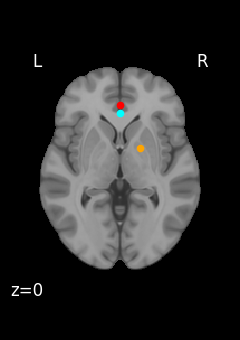

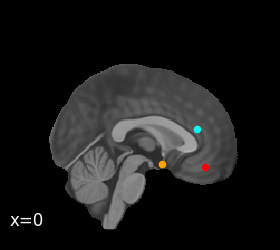

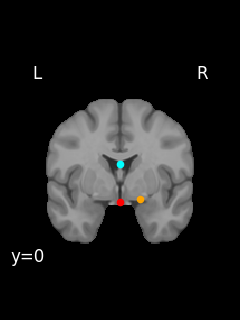

{'OFC': 'red', 'ACC': 'cyan', 'HIP': 'orange'}


In [103]:
template = datasets.load_mni152_template()

# grab most distal channels for each electrode
# IDs were different for older recording system (pt12)
if patient == 12: plot_chanIDs = [97, 105, 113]
else: plot_chanIDs = [193, 202, 210]

coords_list = []
for ch in plot_chanIDs:
    row = final_neur_df[final_neur_df['chanID'] == ch].iloc[0]   # first match
    coords_list.append([row.x, row.y, row.z])

coords = np.array(coords_list)

coord_regions  = ['OFC', 'ACC', 'HIP']
colors = {'OFC':'red', 'ACC':'cyan', 'HIP':'orange'}
marker_size = 20
# x = sagittal, y = coronal, z = axial

# 1. axial
# fix z (axial)
axial_cut = 0
coords_ax = coords.copy()
coords_ax[:,2] = axial_cut
disp1 = plotting.plot_anat(template, display_mode='z', cut_coords=[axial_cut],
                           cmap='gray', black_bg=True, draw_cross=False, colorbar=False)
for (x,y,z), name in zip(coords_ax, coord_regions):
    disp1.add_markers([(x,y,z)], marker_size=marker_size, marker_color=colors[name])
    
# 2. sagittal (x=0)
sag1_cut = 0
coords_sag1 = coords.copy()
coords_sag1[:,0] = sag1_cut
disp2 = plotting.plot_anat(template, display_mode='x', cut_coords=[sag1_cut],
                           cmap='gray', black_bg=True, draw_cross=False, colorbar=False)
for (x,y,z), name in zip(coords_sag1, coord_regions):
    disp2.add_markers([(x,y,z)], marker_size=marker_size, marker_color=colors[name])

# 3. coronal (y=30)
cor_cut = 0
coords_cor = coords.copy()
coords_cor[:,1] = cor_cut
disp4 = plotting.plot_anat(template, display_mode='y', cut_coords=[cor_cut],
                           cmap='gray', black_bg=True, draw_cross=False, colorbar=False)
for (x,y,z), name in zip(coords_cor, coord_regions):
    disp4.add_markers([(x,y,z)], marker_size=marker_size, marker_color=colors[name])

plotting.show()

print(colors)